In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.layers import ( 
    MaxPool2D, Conv2D, Input,
    BatchNormalization, Dense, Activation,Flatten, Lambda, Add, Concatenate,
    GlobalAveragePooling2D,
    GlobalMaxPooling2D
)

from tensorflow.keras import (
    Model, Sequential, utils, losses, metrics,
    optimizers, backend as K, callbacks,
    applications)

import h5py
import os
import seaborn as sns
import tensorflow as tf

from circles import (
    make_complex_circle, 
    make_simple_circle, 
    make_complex_dataset, 
    make_simple_dataset,
    make_mesh,
    build_variate_dataset,
    read_dataset,
    run_multiprocess,
    structure_data
)

from utils import (
    display_images,
    moving_average,
    plot_history,
    predict_and_errors,
    read_image
)

In [3]:
# Constant values
IMG_SIZE = 256
BATCH_SIZE = 64

In [4]:
# If you are using google drive...

#from google.colab import drive
#data_path = 'drive/MyDrive/Notebooks management/Analysis/Circles counting'

In [5]:
from tensorflow.python.ops.gen_math_ops import add
def cnn_count_model(shape):
    w, h, c = shape
    inputs = Input([w, h, c])
    conv_batch_1 = conv_layer(16, 7, 1)
    conv_batch_2 = conv_layer(32, 5, 1)
    conv_batch_3 = conv_layer(64, 5, 1)
    conv_batch_4 = conv_layer(128, 5, 1, False)
    flatten = Flatten()
    dense_1 = Dense(150, activation="relu")
    outputs = Dense(1, activation="linear")

    x = conv_batch_1(inputs)
    x = conv_batch_2(x)
    x = conv_batch_3(x)
    x = conv_batch_4(x)
    x = flatten(x)
    x = dense_1(x)
    outputs = outputs(x)

    return Model(inputs, outputs)

def conv_layer(n_filters, kernel=3, strides=1, padding='valid', on_max=True):
    seq = Sequential(
      [
       Conv2D(n_filters, kernel, strides, padding),
       BatchNormalization(),
       Activation('relu')
      ]
    )
    if on_max:
        seq.add(MaxPool2D(2, 2))

    return seq

## 1. Example of image generation, model training and evaluation

### One sample image with circles

Skip this part if your dataset has already being created

In [ ]:
circle_map = make_simple_circle()
print(f"Shape and number of positive pixels {circle_map.shape}, {circle_map.sum()}")
_ = plt.imshow(circle_map)

### Dataset creation

In [ ]:
images, target = make_simple_dataset(n_examples=50)
target = target.reshape(-1, 1)

print(f"Shape and number of positive pixels {images.shape}, {images.sum()}")
print(f"Target shape {target.shape}")
_ = plt.imshow(circle_map)

### Base model: build and training

In [ ]:
model = cnn_count_model((128, 128, 1))

In [ ]:
utils.plot_model(model, show_shapes=True)

In [ ]:
initial_learning_rate = 0.05
decay_steps = 1.0
decay_rate = 0.5
schedule = optimizers.schedules.InverseTimeDecay(initial_learning_rate,
                                                 decay_steps,
                                                 decay_rate)
call_backs = [callbacks.EarlyStopping(monitor='val_loss',
                                     min_delta=3,
                                     patience=10,
                                     restore_best_weights=True),
             callbacks.LearningRateScheduler(schedule)
             ]

loss = losses.MeanAbsolutePercentageError()
optimizer = optimizers.Adam(learning_rate=initial_learning_rate)
metric = [
          #metrics.MeanAbsoluteError(),
          metrics.MeanSquaredError(),
          #metrics.MeanAbsolutePercentageError()]
]
model.compile(optimizer='rmsprop',
              loss=loss,
              metrics=metric
              )

model_history = model.fit(x=images, y=target,
                          batch_size=BATCH_SIZE,
                          epochs=50,
                          shuffle=True,
                          validation_split=0.1,
                          callbacks=call_backs
                          )

### Evaluation

#### Evaluation over random training data

In [ ]:
output = Lambda(lambda x: K.round(x)) (model.output)

In [ ]:
sample_indices = np.random.choice(np.arange(0, len(images)), 10, replace=False)
sample_images = images[sample_indices]
sample_target = target[sample_indices]

predict_and_errors(model, sample_images, sample_target)

Evaluation over unseen data with 1 to 10 circles.

In [ ]:
test_images, test_target = make_simple_dataset(n_examples=20, min_n_circles=1, max_n_circles=10)
test_images.shape, test_target.shape

In [ ]:
predict_and_errors(model, test_images[:5], test_target[:5])

Evaluation over unseen data with 10 to 50 circles.

In [ ]:
test_images_extra, test_extra_target = make_simple_dataset(n_examples=50, min_n_circles=10, max_n_circles=50)
test_images_extra.shape, test_extra_target.shape

In [ ]:
pred_extra, error_extra = predict_and_errors(model, 
                                             test_images_extra, 
                                             test_extra_target, 
                                             on_return=True, 
                                             on_show=False)

#### Plot frequency of predicted circle counts

In [ ]:
def df_evaluation(error, pred):
    pred_round = np.round(pred).astype('uint8')
    df = pd.DataFrame(data={'error': error.reshape(-1),
                            'pred': pred_round.reshape(-1)},
                            columns=[
                                'error', 
                                'pred'
                                ]
                                )
    return df.sort_values("pred")

In [ ]:
df = df_evaluation(error_extra, pred_extra)
sns.barplot(data=df.groupby('pred').mean().reset_index(), 
            x='pred', 
            y='error',
            )
_ = plt.xticks(rotation=30)

We see how mean prediction error increases when prediction is higher. This might
be because training limited to 1 to 10 range, thus, when unseen examples with more
than 10 circles are to be evaluated, the model performs worse.

Let's check the examples with unusual number of circles to get insights of the distribution of the circles.m

In [ ]:
display_images(test_images_extra, 
               test_extra_target, 
               n_examples=5)

Many circles overlap with each other, creating a cluster and losing the
circle like shape. This might lead the model to not properly detect individual
circles. This model downsize could be expected if training set only contains overall perfectly separated circles.

However, we can improve the data set maker function to avoid circles from overlapping. Another additional improvement would be using grayscale images, in other words, mostly black background and gray circles with variation of magnitude to allow the model to learn more complex features and end up generalizing in more real-world examples like images taken from cameras.

## 2. Enhance features of circle dataset functions

These new function allows:
+ Variate radius (can define min and max radius)
+ Variate circle gray intensity
+ between-circles separation control
+ bounding-walls-to-circles separation control

(256, 256)

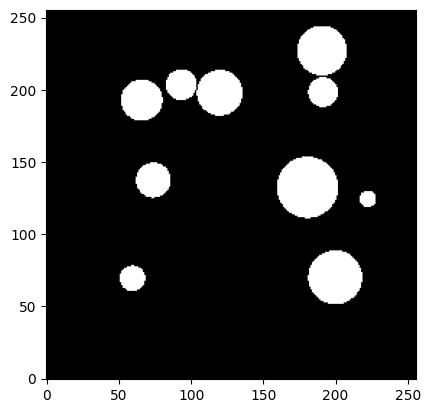

In [4]:
n = 10
images = make_complex_circle(n, img_size=256, max_gray=0.0)
plt.imshow(images, cmap="grey", origin="lower")
images.shape

#### Make new dataset

The next cell will make a dataset of images, but it will take some time to complete it, for example 1 image of shape (256, 256) can take around 2s. In order to make the code run a little faster, we will use a multiprocess function.

In [3]:
# Code below with given parameters might take around 1 hour to be completed
#images_gray, target_gray = make_complex_dataset(n_min_examples=10, size=256, max_n_circles=20, on_balanced=False)
#print(images_gray.shape, target_gray.shape)

100%|██████████| 10/10 [00:19<00:00,  1.95s/it]

(10, 256, 256, 1) (10,)


In [5]:
n = 1000
n_processes = 10
n_per_process = int(n / n_processes)
min_n_circles = 1
max_n_circles = 20

images_gray, target_gray = structure_data(run_multiprocess(make_complex_dataset, 
                                                           n_processes, 
                                                           n_per_process, 
                                                           IMG_SIZE, 
                                                           min_n_circles, 
                                                           max_n_circles, 
                                                           False))
print(images_gray.shape, target_gray.shape)

(1000, 256, 256, 1) (1000,)


In [9]:
# Save the images in h5 format dataset
file_name = f"circle_images_{min_n_circles}_{max_n_circles}_{IMG_SIZE}_{IMG_SIZE}.hdf5"

with h5py.File(f"./{file_name}", "w") as f:
    f.create_dataset("images", data=images_gray)
    f.create_dataset("target", data=target_gray)
os.listdir()

['.git',
 '.ipynb_checkpoints',
 'circles.py',
 'Circle_detection_make_data.ipynb',
 'Circle_detection_models.ipynb',
 'circle_images_1_20_256_256.hdf5',
 'Circle_segmentation.ipynb',
 'LICENSE',
 'README.md',
 'two datasets for testing.zip',
 'two real images for testing.zip',
 'unit_testing.ipynb',
 'utils.py',
 '__pycache__']

#### Load the dataset from disk

In [6]:
from zipfile import ZipFile

with ZipFile('images_with_circles.zip') as zip_handler:
    for zip_info in zip_handler.filelist:
        f_name = zip_info.filename
        if "20_256_256" in f_name:
            with zip_handler.open(f_name, "r") as f:
                h5py_file = h5py.File(f)
                images_gray = h5py_file.get('images')[:]
                target_gray = h5py_file.get('target')[:]
print(images_gray.shape)
print(target_gray.shape)

(1000, 256, 256, 1)
(1000,)


Distribution of number of circles in gray images

<BarContainer object of 20 artists>

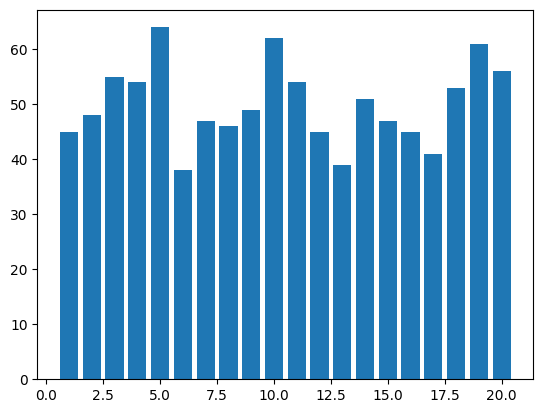

In [6]:
u, c = np.unique(target_gray, return_counts=True)
plt.bar(x=u, height=c)

These parameters don't outcome a proper model

+ epochs = 110
+ initial_learning_rate = 0.1
+ decay_steps = 1.0
+ decay_rate = 0.5
+ min_delta = 2
+ patience = 120

Metrics
+ metrics.MeanAbsoluteError(),
+ metrics.MeanSquaredError(),

In [10]:
model_2 = cnn_count_model((IMG_SIZE, IMG_SIZE, 1))

epochs = 100
patience = 10
initial_learning_rate = 0.1
decay_steps = 1.0
decay_rate = 0.5

## Callbacks
# Time decay callback
schedule = optimizers.schedules.InverseTimeDecay(
    initial_learning_rate,
    decay_steps,
    decay_rate
)
call_backs = [callbacks.EarlyStopping(
    monitor='loss',
    min_delta=1.0,
    patience=patience,
    restore_best_weights=True),
              callbacks.LearningRateScheduler(schedule)
             ]

# Loss
loss = losses.MeanSquaredError()
# Optimizer
optimizer = optimizers.Adam(learning_rate=initial_learning_rate)
# Metrics
metric = [
    metrics.MeanAbsoluteError(),
    #metrics.MeanSquaredError(),
    metrics.MeanAbsolutePercentageError()
]
# Compilation and model fitting
model_2.compile(
    optimizer='rmsprop',
    loss=loss,
    metrics=metric
)

model_history_2 = model_2.fit(x=images_gray, y=target_gray,
                              batch_size=BATCH_SIZE,
                              epochs=epochs,
                              shuffle=True,
                              validation_split=0.1,
                              callbacks=call_backs
                              )

model_history_2

Epoch 1/80
15/15 [==============================] - 29s 2s/step - loss: 55633.3906 - mean_absolute_error: 89.2210 - mean_absolute_percentage_error: 1117.5098 - val_loss: 4088002.5000 - val_mean_absolute_error: 2012.5897 - val_mean_absolute_percentage_error: 29938.6445 - lr: 0.1000
Epoch 2/80
15/15 [==============================] - 28s 2s/step - loss: 149.4088 - mean_absolute_error: 9.6469 - mean_absolute_percentage_error: 171.1711 - val_loss: 113761.2188 - val_mean_absolute_error: 323.1603 - val_mean_absolute_percentage_error: 3992.3196 - lr: 0.0667
Epoch 3/80
15/15 [==============================] - 28s 2s/step - loss: 626.5841 - mean_absolute_error: 16.2457 - mean_absolute_percentage_error: 316.8114 - val_loss: 35260.9844 - val_mean_absolute_error: 184.2356 - val_mean_absolute_percentage_error: 2535.0952 - lr: 0.0500
Epoch 4/80
15/15 [==============================] - 28s 2s/step - loss: 1172.0619 - mean_absolute_error: 31.2356 - mean_absolute_percentage_error: 455.5836 - val_loss: 

In [11]:
model_2.save("counter_4_conv2DBatch_1_hidden.keras")

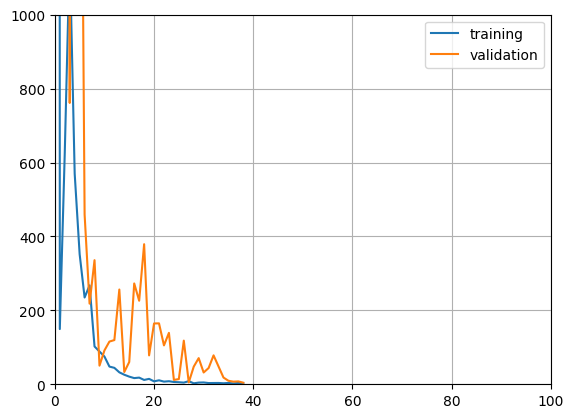

In [12]:
plot_history(model_history_2, lim=(0, 100, 0, 1000))

Evaluation of training set sample

1/1 [==============================] - 0s 201ms/step


(None, None)

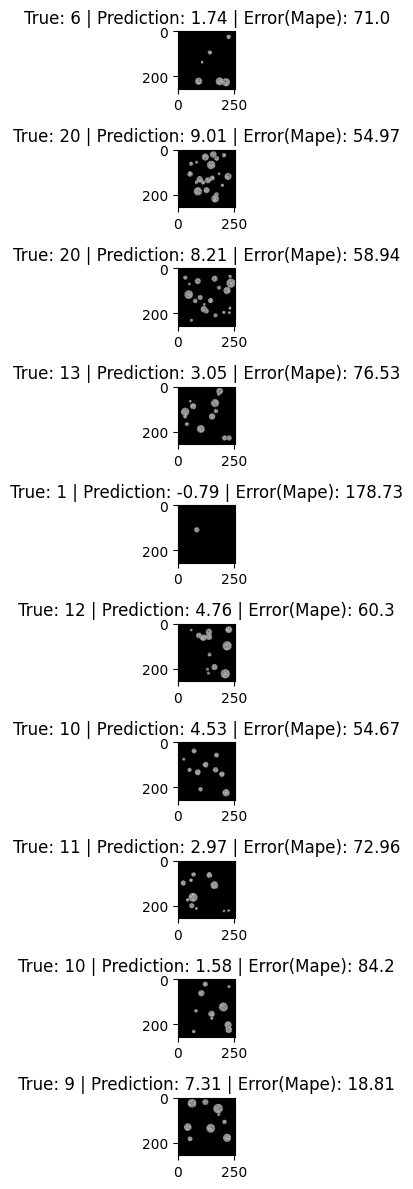

In [13]:
n_samples = 10

sample_indices = np.random.choice(np.arange(0, len(images_gray)), 
                                  n_samples, 
                                  replace=False)
sample_images = images_gray[sample_indices]
sample_target = target_gray[sample_indices].reshape(-1, 1)

predict_and_errors(model_2, sample_images, sample_target)

In [30]:
test_images, test_target = structure_data(run_multiprocess(make_complex_dataset, 
                                                           100, 
                                                           int(100/10), 
                                                           IMG_SIZE, 
                                                           1, 
                                                           40, 
                                                           False))
test_target = test_target.reshape(-1, 1)

In [ ]:
print(test_images.shape, test_target.shape)
pred_test, error_test =  predict_and_errors(model_2, 
                                            test_images, 
                                            test_target, 
                                            on_show=False, 
                                            on_return=True)

In [ ]:
predict_and_errors(model_2, test_images[:8], test_target[:8])

In [ ]:
pred_test, error_test =  predict_and_errors(model_2, test_images, test_target, on_show=False, on_return=True)
df = df_evaluation(error_test, pred_test)
sns.barplot(data=df.groupby('pred').mean().reset_index(), x='pred', y='error')
plt.xticks(rotation=30)

In [ ]:
pred_test, error_test =  predict_and_errors(model_2, test_images, test_target, on_show=False, on_return=True)
df = df_evaluation(error_test, pred_test)
sns.barplot(data=df.groupby('pred').mean().reset_index(), x='pred', y='error')
plt.xticks(rotation=30)

In [ ]:
pred_test, error_test =  predict_and_errors(model_4, test_images, test_target, on_show=False, on_return=True)
df = df_evaluation(error_test, pred_test)
sns.barplot(data=df.groupby('pred').mean().reset_index(), x='pred', y='error')
plt.xticks(rotation=30)

We conclude that model with MAPE loss gives better performance in terms of lower absolute error, even with values out of the training range up to 17 circles, for which we find the mean error (difference is 2).

We could try to improve this by

- Increasing number of filters in cnn layers.
- Better kernel, for example 3 to 5 or 5 to 7, size and downsampling
- Adding more cnn layers
- Adding skip layers (resnet) (concatenation or addition)

### Convolutional counting model with residual connection

In [ ]:
def res_cnn_counter(shape):
    w, h, c = shape
    inputs = Input([w, h, c])
    conv_batch_1_1 = conv_layer(16, 7, 1)
    conv_batch_1_2 = conv_layer(16, 7, 1, "same", False)
    conv_batch_2_1 = conv_layer(32, 5, 1)
    conv_batch_2_2 = conv_layer(32, 5, 1, "same", False)
    conv_batch_3_1 = conv_layer(64, 5, 1)
    conv_batch_3_2 = conv_layer(64, 5, 1, "same", False)
    conv_batch_4_1 = conv_layer(128, 5, 1)
    flatten = Flatten()
    dense_1 = Dense(150, activation="relu")
    outputs = Dense(1, activation="linear")

    # Sublayer
    x = conv_batch_1_1(inputs)
    x = conv_batch_1_2(x) + x

    x = conv_batch_2_1(x)
    x = conv_batch_2_2(x) + x

    x = conv_batch_3_1(x)
    x = conv_batch_3_2(x) + x

    x = conv_batch_4_1(x)

    x = flatten(x)
    x = dense_1(x)
    outputs = outputs(x)

    return Model(inputs, outputs)

## Pretrained VGG16 model

In [ ]:
pretrained_vgg = applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling='max',
    classes=None,
    classifier_activation=None
)

vgg_preprocess = applications.vgg16.preprocess_input

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.layers import Layer

In [ ]:
def model_vgg_plus_dense(vgg_layers, extra_layers, input_shape):
    inputs = Input(input_shape)
    x = inputs
    for l in vgg_layers:
        x = l(x)

    for l in extra_layers:
        x = l(x)
    outputs = x
    return Model(inputs=inputs, outputs=outputs)

In [ ]:
n_layers = 6
selected_layers = [x for x in pretrained_vgg.layers[1:n_layers + 1]] # [pretrained_vgg.layers[-1]
[x.output.shape for x in selected_layers]

In [ ]:
layers = [
          tf.keras.layers.GlobalMaxPooling2D(),
          Dense(64, activation='relu'),
          Dense(128, activation='relu'),
          Dense(1, activation='linear')
        ]

In [ ]:
model_pretrained = model_vgg_plus_dense(selected_layers, layers, [224, 224, 3])
model_pretrained.summary()

In [ ]:
images_gray_3_channel = tf.repeat(images_gray, 3, axis=-1)
images_gray_3_channel.shape

In [ ]:
patience = 200
epochs = 50
initial_learning_rate = 0.1
decay_steps = 1.0
decay_rate = 0.5
schedule = optimizers.schedules.InverseTimeDecay(initial_learning_rate,
                                                 decay_steps,
                                                 decay_rate)
call_backs = [callbacks.EarlyStopping(monitor='loss',
                                     min_delta=2,
                                     patience=patience,
                                     restore_best_weights=True),
             callbacks.LearningRateScheduler(schedule)
             ]

loss = losses.MeanAbsolutePercentageError()
optimizer = optimizers.Adam(learning_rate=initial_learning_rate)
metric = [
          metrics.MeanAbsoluteError(),
          metrics.MeanSquaredError(),
          #metrics.MeanAbsolutePercentageError()]
]
model_pretrained.compile(optimizer=optimizer,
                loss=loss,
                metrics=metric
                )
model_pretrained_history = model_pretrained.fit(x=images_gray_3_channel, y=target_gray,
                              batch_size=100,
                              epochs=epochs,
                              shuffle=True,
                              validation_split=0.1,
                              callbacks=call_backs
                              )

In [ ]:
plot_history(model_pretrained_history, lim=[0, 55, 70, 100])

## Real-world images

In [ ]:
def read_image(data_path, img_path):
    full_path = os.path.join(data_path, img_path)
    img = utils.load_img(full_path,
                         grayscale=True,
                         color_mode='rgb',
                         target_size=(224, 224),
                         interpolation='nearest',
                         )
    img = utils.img_to_array(img, data_format='channels_last', dtype=None)
    return img

In [ ]:
os.listdir()

In [ ]:
test_img_0 = read_image(data_path, 'real_image_0.jpg')
test_img_0 = tf.expand_dims(test_img_0, axis=0)
test_img_1 = read_image(data_path, 'real_image_1.jpg')
test_img_1 = tf.expand_dims(test_img_1, axis=0)

In [ ]:
plt.imshow(test_img_0[..., 0], cmap='Greys_r')

In [ ]:
plt.imshow(test_img_1[..., 0], cmap='Greys_r')

In [ ]:
p, e = predict_and_errors(model_2, 
                          tf.concat([test_img_0, test_img_1], 
                                    axis=0), 
                          [14, 6], 
                          on_show=False, 
                          on_return=True)
test_img_0.shape, p, e 

In [ ]:
p

## Noise addition to image background

In [ ]:
from tensorflow.python.ops.gen_math_ops import add
def cnn_count_model(shape):
    w, h, c = shape
    inputs = Input([w, h, c])
    layer_1 = conv_layer(16, 5, 1)
    layer_2 = conv_layer(32, 5, 1)
    layer_3 = conv_layer(64, 5, 1)
    layer_4 = conv_layer(128, 5, 2)
    #layer_5 = Conv2D(32, 1, 1)
    flatten = Flatten()
    layer_6 = Dense(1, activation="linear")

    x = layer_1(inputs)
    x = layer_2(x)
    x = layer_3(x)
    x = layer_4(x)
    #x = layer_5(x)
    x = flatten(x)
    outputs = layer_6(x)

    return Model(inputs, outputs)

def conv_layer(n_filters, kernel=3, strides=1, padding='valid', on_max=True):
    seq = Sequential(
      [
       Conv2D(n_filters, kernel, strides, padding),
       Activation('relu'),
       BatchNormalization(),
      ]
    )
    if on_max:
    seq.add(MaxPool2D(2, 2))

    return seq

In [ ]:
drive.mount('drive')

In [ ]:
def build_variate_dataset(root_path,
                          file_name,
                          noises_strength=[0.05],
                          on_shuffle=True,
                          ):
    images_gray, y = read_dataset(root_path, file_name)
    stacks = []
    stacks.append(images_gray)
    for noise_strength in noises_strength:
        stacks.append(images_gray + noise_strength * np.random.rand(*images_gray.shape))
    images_concat = np.concatenate(stacks, axis=0)
    images_values_inverted = np.ones(images_concat.shape) - images_concat
    images_concat = np.concatenate([images_concat,
                                  images_values_inverted], axis=0)
    n_stacks = 2 * len(stacks)
    y_concat = np.concatenate([y] * n_stacks,
                              axis=0)
    if on_shuffle:
        indices = np.arange(len(images_concat))
        np.random.shuffle(indices)
        images_concat = images_concat[indices]
        y_concat = y_concat[indices]
    return np.clip(images_concat, 0.0, 1.0), y_concat

def read_dataset(root_path, file_name):
    file_path = os.path.join(root_path, file_name)
    with h5py.File(file_path, "r") as f:
        images_gray = f.get('images')[:]
        target_gray = f.get('target')[:]
    print("Shape of extracted images:", images_gray.shape)
    print("Shape of extracted targets:", target_gray.shape)
    return images_gray, target_gray

In [ ]:
file_name = "circle_images_20_224_224.hdf5"
root_path = data_path

images_concat, y_concat = build_variate_dataset(root_path,
                                                file_name,
                                                noises_strength=[0.05,
                                                                 0.15,
                                                                 0.3,
                                                                ]
                                               )
print(images_concat.shape, y_concat.shape)
plt.imshow(images_concat[0], cmap="Greys_r")

In [ ]:
model_part_4_id_1 = cnn_count_model((224, 224, 1))

# Setup
epochs = 200
patience = 500
initial_learning_rate = 0.01
decay_steps = 1.0
decay_rate = 0.1
batch_size = 128
val_split = 0.1
on_shuffle = False
# schedule
schedule = optimizers.schedules.InverseTimeDecay(initial_learning_rate,
                                                 decay_steps,
                                                 decay_rate)
# Callbacks
call_backs = [callbacks.EarlyStopping(monitor='loss',
                                     min_delta=0.5,
                                     patience=patience,
                                     restore_best_weights=True),
             callbacks.LearningRateScheduler(schedule)
             ]
# Loss, optimizer and metric
loss = losses.MeanSquaredError()
optimizer = optimizers.Adam(learning_rate=initial_learning_rate)
metric = [
          metrics.MeanAbsoluteError(),
          metrics.MeanAbsolutePercentageError()
          ]
# Model compilation and training (fit)
model_part_4_id_1.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=metric
                          )

history_part_4_id_1 = model_part_4_id_1.fit(x=images_concat,
                                            y=y_concat,
                                            batch_size=batch_size,
                                            epochs=epochs,
                                            shuffle=on_shuffle,
                                            validation_split=val_split,
                                            callbacks=call_backs
                                            )

In [ ]:
utils.plot_model(model_part_4_id_1, show_shapes=True)

In [ ]:
plot_history(history_part_4_id_1, lim=(0, epochs, 0, 20))

In [ ]:
model_part_4_id_1.save("./circle counter_1_1 to 20_mixed training.keras")

In [ ]:
sample_indices = np.random.choice(np.arange(0, len(images_concat)), 10, replace=False)
sample_images = images_concat[sample_indices]
sample_target = y_concat[sample_indices]

predict_and_errors(model_part_4_id_1, sample_images, sample_target)

In [ ]:
test_images, test_target = make_data(n_examples=10, size=224, min_n_circles=1, max_n_circles=10)
print(test_images.shape, test_target.shape)

predict_and_errors(model_part_4_id_1, test_images, test_target)

In [ ]:
print(model_part_4_id_1(test_images[[5]]))
plt.imshow(test_images[5], cmap="Greys_r")

#### from fully dense layer to GAP (Global average pooling) layer on top

In [ ]:
from tensorflow.python.ops.gen_math_ops import add
def cnn_count_model(shape):
    w, h, c = shape
    inputs = Input([w, h, c])
    layer_1 = conv_layer(16, 7, 1, padding="same", on_max=False)
    layer_2 = conv_layer(16, 7, 1, on_max=True)
    layer_3 = conv_layer(32, 5, 1, on_max=False)
    layer_4 = conv_layer(32, 5, 2, on_max=True)
    layer_5 = conv_layer(64, 3, 1, on_max=False)
    layer_6 = conv_layer(64, 3, 1, on_max=False)
    layer_7 = GlobalAveragePooling2D()
    layer_8 = Dense(1, activation="linear")

    x = layer_1(inputs)
    x = layer_2(x)
    x = layer_3(x)
    x = layer_4(x)
    x = layer_5(x)
    x = layer_6(x)
    x = layer_7(x)
    outputs = layer_8(x)

    return Model(inputs, outputs)

def conv_layer(n_filters, kernel=3, strides=1, padding='valid', on_max=True):
    seq = Sequential(
        [
           Conv2D(n_filters, kernel, strides, padding),
           Activation('relu'),
           BatchNormalization(),
        ]
    )
    if on_max:
        seq.add(MaxPool2D(2, 2))

    return seq

## Segmentation models with pytorch

In [ ]:
from torch import nn

import torch

from torchvision import models
from torchvision.transforms import v2
from torchsummary import summary

torch.manual_seed(0)

from torchvision.models.detection import (
    maskrcnn_resnet50_fpn_v2,
    MaskRCNN_ResNet50_FPN_V2_Weights
)

model = models.get_model("maskrcnn_resnet50_fpn_v2", 
                         weights="MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1", 
                         weights_backbone=None)

weights = MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT
transforms = weights.transforms()
model = maskrcnn_resnet50_fpn_v2()
model.training = False
model